<a href="https://www.kaggle.com/code/loopedward/forecast-your-site-visits?scriptVersionId=141208147" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Ingest

In [1]:
import pandas as pd

FILE_LOCATION = '/kaggle/input/daily-website-visitors/daily-website-visitors.csv'

whole_dataset = pd.read_csv(FILE_LOCATION, 
                            index_col='Date',
                            thousands=',')
whole_dataset

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
9/14/2014,1,Sunday,1,2146,1582,1430,152
9/15/2014,2,Monday,2,3621,2528,2297,231
9/16/2014,3,Tuesday,3,3698,2630,2352,278
9/17/2014,4,Wednesday,4,3667,2614,2327,287
9/18/2014,5,Thursday,5,3316,2366,2130,236
...,...,...,...,...,...,...,...
8/15/2020,2163,Saturday,7,2221,1696,1373,323
8/16/2020,2164,Sunday,1,2724,2037,1686,351
8/17/2020,2165,Monday,2,3456,2638,2181,457


In [2]:
whole_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2167 entries, 9/14/2014 to 8/19/2020
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Page.Loads         2167 non-null   int64 
 4   Unique.Visits      2167 non-null   int64 
 5   First.Time.Visits  2167 non-null   int64 
 6   Returning.Visits   2167 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 135.4+ KB


In [3]:
whole_dataset.describe()

,Row,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
count,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000
mean,1084.000000,3.997231,4116.989386,2943.646516,2431.824181,511.822335
std,625.703338,2.000229,1350.977843,977.886472,828.704688,168.736370
min,1.000000,1.000000,1002.000000,667.000000,522.000000,133.000000
25%,542.500000,2.000000,3114.500000,2226.000000,1830.000000,388.500000
50%,1084.000000,4.000000,4106.000000,2914.000000,2400.000000,509.000000
75%,1625.500000,6.000000,5020.500000,3667.500000,3038.000000,626.500000
max,2167.000000,7.000000,7984.000000,5541.000000,4616.000000,1036.000000


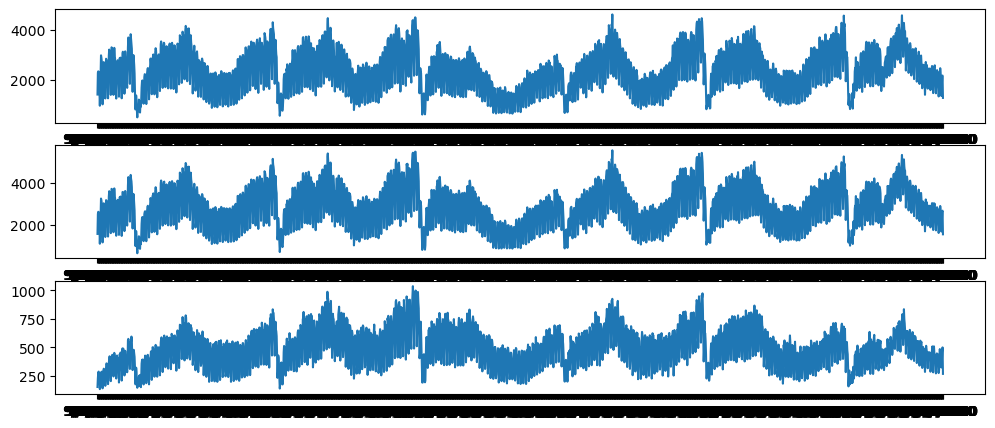

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(12, 5))

axs[0].plot(whole_dataset['First.Time.Visits'])
axs[1].plot(whole_dataset['Unique.Visits'])
axs[2].plot(whole_dataset['Returning.Visits'])
plt.show()

# Preprocessing the data

* Target Attribute: **Returning.Visits** 
We shall predict the **Returning.Visits** given past data.


In [5]:
target_column = whole_dataset['Returning.Visits']
target_column

Date
9/14/2014    152
9/15/2014    231
9/16/2014    278
9/17/2014    287
9/18/2014    236
            ... 
8/15/2020    323
8/16/2020    351
8/17/2020    457
8/18/2020    499
8/19/2020    267
Name: Returning.Visits, Length: 2167, dtype: int64

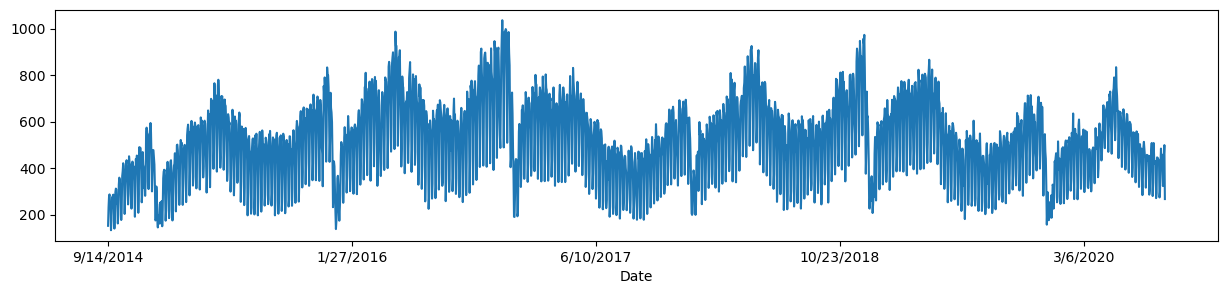

In [6]:
target_column.plot(figsize=(15, 3))
plt.show()

# Compute Train and Test Data Boundaries

In [7]:
len(target_column)

2167

In [8]:
TEST_DATA_PERCENTAGE = 0.2

TEST_DATA_BOUNDARY_INDEX = int((1 - TEST_DATA_PERCENTAGE) * len(target_column))
print(f"Train data:\tReturning Visits [:{TEST_DATA_BOUNDARY_INDEX}]")
print(f"Test data:\tReturning Visits [{TEST_DATA_BOUNDARY_INDEX}:] ({len(target_column) - TEST_DATA_BOUNDARY_INDEX})")
print(f"\nLast target on train data: {target_column[TEST_DATA_BOUNDARY_INDEX]}")

Train data:	Returning Visits [:1733]
Test data:	Returning Visits [1733:] (434)

Last target on train data: 564


## Window-ize the dataset

In [9]:
from tensorflow.keras.utils import timeseries_dataset_from_array

WINDOW_SIZE = 14
train_dataset = timeseries_dataset_from_array(target_column[:-WINDOW_SIZE], 
                                                 target_column[WINDOW_SIZE:], 
                                                 sequence_length=WINDOW_SIZE,
                                                 end_index=TEST_DATA_BOUNDARY_INDEX)
len(train_dataset), len(list(train_dataset.unbatch()))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

(14, 1720)

In [10]:
target_column[1700:1751].values, (list(train_dataset)[-1][0][-1].numpy(), list(train_dataset)[-1][1][-1].numpy())

(array([417, 495, 772, 692, 678, 624, 541, 331, 410, 636, 593, 659, 545,
        489, 311, 371, 509, 636, 553, 543, 454, 253, 329, 536, 582, 494,
        559, 444, 259, 344, 567, 594, 585, 564, 476, 266, 328, 527, 552,
        531, 478, 422, 242, 304, 442, 523, 489, 474, 364, 216, 254]),
 (array([543, 454, 253, 329, 536, 582, 494, 559, 444, 259, 344, 567, 594,
         585]),
  564))

In [11]:
test_dataset = timeseries_dataset_from_array(target_column[:-WINDOW_SIZE], 
                                                 target_column[WINDOW_SIZE:], 
                                                 sequence_length=WINDOW_SIZE,
                                                 start_index=TEST_DATA_BOUNDARY_INDEX)
len(test_dataset), len(list(test_dataset.unbatch()))

(4, 407)

In [12]:
target_column[1700:1751].values, list(test_dataset)[0][0][0].numpy(), list(test_dataset)[0][1][0].numpy()

(array([417, 495, 772, 692, 678, 624, 541, 331, 410, 636, 593, 659, 545,
        489, 311, 371, 509, 636, 553, 543, 454, 253, 329, 536, 582, 494,
        559, 444, 259, 344, 567, 594, 585, 564, 476, 266, 328, 527, 552,
        531, 478, 422, 242, 304, 442, 523, 489, 474, 364, 216, 254]),
 array([564, 476, 266, 328, 527, 552, 531, 478, 422, 242, 304, 442, 523,
        489]),
 474)

## Plot the train and test datasets

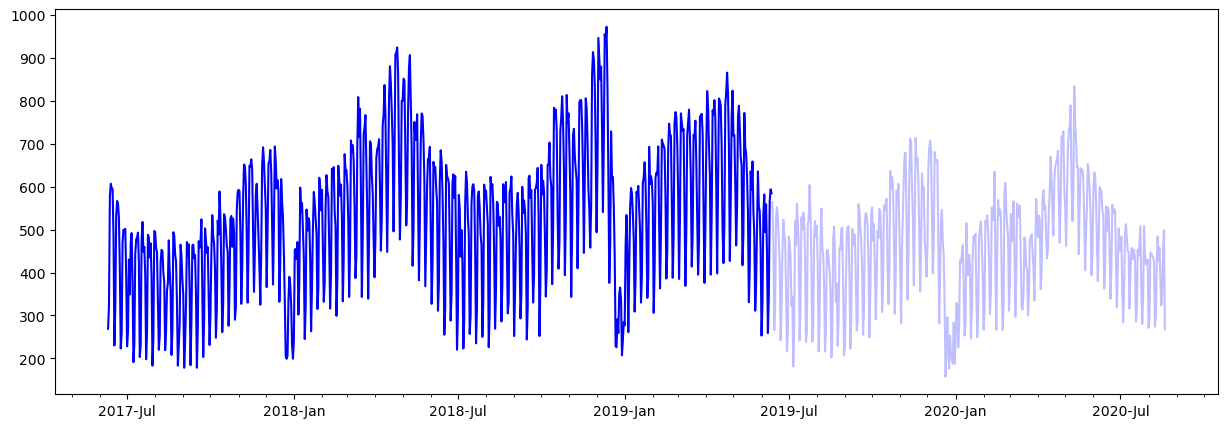

In [13]:
import numpy as np 
import matplotlib.dates as mdates

def plot_time_series(test_dataset, start_index=1000):
    timesteps = pd.to_datetime(target_column.index)
    
    fig,ax = plt.subplots(1,figsize=(15,5))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    
    # Plot train dataset
    plt.plot(timesteps[start_index:TEST_DATA_BOUNDARY_INDEX], target_column[start_index:TEST_DATA_BOUNDARY_INDEX],
            color='blue')
    
    # Plot test dataset
    plt.plot(timesteps[TEST_DATA_BOUNDARY_INDEX:], target_column[TEST_DATA_BOUNDARY_INDEX:],
             color='blue', alpha=0.25)

    
plot_time_series(test_dataset)